In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

## Initial Analysis

In [265]:
df = pd.read_csv('train.csv')
df_submit = pd.read_csv('test.csv')

In [266]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [267]:
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

### Missing Values

% of missing values in train...

In [268]:
df.isnull().sum()/len(df)*100

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

...and submit datasets

In [269]:
df_submit.isnull().sum()/len(df_test)*100

PassengerId     0.000000
HomePlanet      2.034136
CryoSleep       2.174421
Cabin           2.338087
Destination     2.151040
Age             2.127660
VIP             2.174421
RoomService     1.917232
FoodCourt       2.478373
ShoppingMall    2.291326
Spa             2.361468
VRDeck          1.870470
Name            2.197802
dtype: float64

### Finding 1 => Initial Analysis and missing values.
- We will have to transform column and data to lowercase, remove spaces, etc
- There are categorical variables (PassengerId and Cabin) than we can split in order to obtain several useful features
    - *PassengerId* : Number of members in a group
    - *Cabin* : Deck, Number, Side
- There are missing values in both train and submit datasets, but in a small percentage (< 2.5%). We can replace them with the most frequent values ​​without too much loss of accuracy

## Data Preparation

Adaptating categorical columns

In [270]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

df.cryosleep = pd.to_numeric(df.cryosleep, errors='coerce')
df.vip = pd.to_numeric(df.vip, errors='coerce')
df.transported = pd.to_numeric(df.transported, errors='coerce')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

Split of PassengerId (id / size)

In [271]:
df['groupid'] = df['passengerid'].apply(lambda x: int(x[:4]))
gr = pd.DataFrame(df['groupid'].value_counts()).reset_index().rename({'index': 'groupid', 
                      'groupid': 'groupsize'}, axis=1)
df = df.merge(gr, on='groupid', how='left')

Split of Cabin (deck / number / side)

In [272]:
splitcabin = df['cabin'].str.split('/', expand=True).rename({0: 'deck', 1: 'num', 2: 'side'}, axis=1)
df = df.merge(splitcabin, left_index=True, right_index=True, how='left')

I won't use identifier variables (passengerid, cabin, name, groupid, num)

In [273]:
df = df.drop(columns = ['passengerid', 'cabin', 'name', 'groupid', 'num'])

In [274]:
df.describe()

,cryosleep,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,groupsize
count,8476.000000,8514.000000,8490.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,0.358306,28.827930,0.023439,224.687617,458.077203,173.729169,311.138778,304.854791,2.035546
std,0.479531,14.489021,0.151303,666.717663,1611.489240,604.696458,1136.705535,1145.717189,1.596347
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,38.000000,0.000000,47.000000,76.000000,27.000000,59.000000,46.000000,3.000000
max,1.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,8.000000


In [275]:
df.describe(include = ['O'])

,homeplanet,destination,deck,side
count,8492,8511,8494,8494
unique,3,3,8,2
top,earth,trappist-1e,f,s
freq,4602,5915,2794,4288


In order to correct missing values I'm going to impute:
- mean() value in numerical features
- most frequent value in categorical ones

In [276]:
df.cryosleep = df.cryosleep.fillna(df.cryosleep.median()).astype(int)
df.age = df.age.fillna(df.age.mean()).astype(int)
df.vip = df.vip.fillna(df.vip.median()).astype(int)
df.roomservice = df.roomservice.fillna(df.roomservice.mean()).astype(int)
df.foodcourt = df.foodcourt.fillna(df.foodcourt.mean()).astype(int)
df.shoppingmall = df.shoppingmall.fillna(df.shoppingmall.mean()).astype(int)
df.spa = df.spa.fillna(df.spa.mean()).astype(int)
df.vrdeck = df.vrdeck.fillna(df.spa.mean()).astype(int)
df.groupsize = df.groupsize.fillna(df.groupsize.mean()).astype(int)
df.homeplanet = df.homeplanet.fillna('earth')
df.destination = df.destination.fillna('trappist-1e')
df.deck = df.deck.fillna('f')
df.side = df.side.fillna('s')

In [277]:
df.isnull().sum()/len(df)*100

homeplanet      0.0
cryosleep       0.0
destination     0.0
age             0.0
vip             0.0
roomservice     0.0
foodcourt       0.0
shoppingmall    0.0
spa             0.0
vrdeck          0.0
transported     0.0
groupsize       0.0
deck            0.0
side            0.0
dtype: float64

In [278]:
df.dtypes

homeplanet      object
cryosleep        int32
destination     object
age              int32
vip              int32
roomservice      int32
foodcourt        int32
shoppingmall     int32
spa              int32
vrdeck           int32
transported       bool
groupsize        int32
deck            object
side            object
dtype: object

In [29]:
df.nunique()

passengerid     8693
homeplanet         3
cryosleep          2
cabin           6560
destination        3
age               80
vip                2
roomservice     1273
foodcourt       1507
shoppingmall    1115
spa             1327
vrdeck          1306
name            8473
transported        2
group_size      6217
dtype: int64

In [11]:
"""
def make_bool(var):
    if var == None:
        result = None
    elif var == True:
        result = 1
    elif var == False:
        result = 0        
    else:
        result = None
    return result


for i in range(len(df_tmp)):
    df_tmp.iloc[i]['vip'] = make_bool(df_tmp.iloc[i]['vip'])
    df_tmp.iloc[i]['cryosleep'] = make_bool(df_tmp.iloc[i]['cryosleep'])
"""

"\ndef make_bool(var):\n    if var == None:\n        result = None\n    elif var == True:\n        result = 1\n    elif var == False:\n        result = 0        \n    else:\n        result = None\n    return result\n\n\nfor i in range(len(df_tmp)):\n    df_tmp.iloc[i]['vip'] = make_bool(df_tmp.iloc[i]['vip'])\n    df_tmp.iloc[i]['cryosleep'] = make_bool(df_tmp.iloc[i]['cryosleep'])\n"

In [13]:
from sklearn.model_selection import train_test_split

def split_dataframe(dataframe): 
  df_full_train, df_test = train_test_split(dataframe, test_size=0.2, random_state=1)

  df_full_train = df_full_train.reset_index(drop=True)
  df_test = df_test.reset_index(drop=True)

  #y_train = df_train.trip_duration.values
  #y_val = df_val.trip_duration.values
  #y_test = df_test.trip_duration.values

  return df_full_train, df_test

  # df_train.drop(columns=['trip_duration'], inplace=True)
  # df_val.drop(columns=['trip_duration'], inplace=True)

In [14]:
df_rest, df_tmp = train_test_split(df, test_size=0.1, random_state=1)
df_full_train, df_test = split_dataframe(df_tmp)

#### We impute missing_values
- Categorical: Space
- Numerical: Zero or mean()

In [15]:
# Imputamos los distintos valores



In [16]:
df

,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported
0,0001_01,europa,0.0,b/0/p,trappist-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,maham_ofracculy,False
1,0002_01,earth,0.0,f/0/s,trappist-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,juanna_vines,True
2,0003_01,europa,0.0,a/0/s,trappist-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,altark_susent,False
3,0003_02,europa,0.0,a/0/s,trappist-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,solam_susent,False
4,0004_01,earth,0.0,f/1/s,trappist-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,willy_santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,europa,0.0,a/98/p,55_cancri_e,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,gravior_noxnuther,False
8689,9278_01,earth,1.0,g/1499/s,pso_j318.5-22,18.0,0.0,0.0,0.0,0.0,0.0,0.0,kurta_mondalley,False
8690,9279_01,earth,0.0,g/1500/s,trappist-1e,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,fayey_connon,True
8691,9280_01,europa,0.0,e/608/s,55_cancri_e,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,celeon_hontichre,False


In [17]:
df.dtypes

passengerid      object
homeplanet       object
cryosleep       float64
cabin            object
destination      object
age             float64
vip             float64
roomservice     float64
foodcourt       float64
shoppingmall    float64
spa             float64
vrdeck          float64
name             object
transported        bool
dtype: object

#### Cambios
- Pasar booleanos a 0-1

## Linear Regression

In [ ]:
from sklearn import linear_model
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold

# Functions to calculate Linear Regression model
def LR_train(df_train, df_val, features, apply_log):
    # OHE
    dv = DictVectorizer(sparse=False)
    train_dict = df_train[features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    val_dict = df_val[features].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    y_train = df_train.trip_duration.values

    if apply_log:
      y_train_m = np.log1p(y_train)
    else:
      y_train_m = y_train

    model = linear_model.LinearRegression()
    model.fit(X_train, y_train_m)

    return(model,X_train,X_val)
  
def LR_predict(X_train, X_val, model, apply_log):
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    if apply_log:
      y_pred_train = np.exp(y_pred_train) - 1
      y_pred_val = np.exp(y_pred_val) - 1

    # To avoid values < 0 in RMSLE calculation
    y_pred_train = np.where(y_pred_train < 0, 0, y_pred_train)
    y_pred_val = np.where(y_pred_val < 0, 0, y_pred_val)

    return(y_pred_train, y_pred_val)

def LR_calculate(features, apply_log=False, n_splits=3): # Number of splits for Cross validation by default is 3 because it's a very large dataset
    # Cross-Validating
    print('Doing validation with %s splits' % n_splits)
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores_train = []
    scores_val = []
    fold = 0

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        model, X_train, X_val = LR_train(df_train, df_val, features, apply_log)
        y_pred_train, y_pred_val = LR_predict(X_train, X_val, model, apply_log)

        y_train = df_train.trip_duration.values
        y_val = df_val.trip_duration.values
        scores_train.append(round(rmsle(y_train, y_pred_train),4))
        scores_val.append(round(rmsle(y_val, y_pred_val),4))

        # Calculates and prints metrics
        print(f'Fold {fold} RMSLE train: {round(rmsle(y_train, y_pred_train),4)} RMSLE val: {round(rmsle(y_val, y_pred_val),4)}...')
        fold = fold + 1

    print('Validation results:')
    print('RMSLE_train: %.3f +- %.3f' % (np.mean(scores_train), np.std(scores_train))) 
    print('RMSLE_val: %.3f +- %.3f' % (np.mean(scores_val), np.std(scores_val))) 

    #Final model
    print("Final model...")
    model, X_train, X_test = LR_train(df_full_train, df_test, features, apply_log)
    y_pred_train, y_pred_test = LR_predict(X_train, X_test, model, apply_log)

    y_train = df_full_train.trip_duration.values
    y_test = df_test.trip_duration.values
   
    print('RMSLE train: ',round(rmsle(y_train, y_pred_train),4), ' RMSLE test: ',round(rmsle(y_test, y_pred_test),4))

In [ ]:
features = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude']
LR_calculate(features, False)

## XGBoost

In [18]:
from sklearn.feature_extraction import DictVectorizer
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [72]:
features = ['homeplanet', 'cryosleep', 'cabin', 'destination', 'age',
            'vip', 'roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck']
            
train_dicts = df_full_train[features].to_dict(orient='records')
val_dicts = df_test[features].to_dict(orient='records')
dv = DictVectorizer(sparse=False) # OHE
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

y_train = df_full_train.transported.values
y_val = df_test.transported.values

features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [73]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [103]:
%%capture output

score = []
for eta in [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]:
  for md in [2, 4, 6, 8, 10, 15]:
    xgb_params = {'eta': eta, 'max_depth': md, 'min_child_weight': 1, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'nthread': 8, 'seed': 1, 'verbosity': 1}   
    watchlist = [(dtrain, 'train'), (dval, 'val')]
    model = xgb.train(xgb_params, dtrain, num_boost_round=1000, verbose_eval=5, evals=watchlist)
    for ni in range(0,1001,5):
      score.append((eta, md))

df_score = pd.DataFrame(score, columns=['eta', 'max_depth'])
df_parse = parse_xgb_output(output)
df_score = pd.concat([df_score, df_parse], axis=1)

In [105]:
df_score.describe()

,eta,max_depth,num_iter,train_auc,val_auc
count,8442.000000,8442.000000,6030.000000,6030.000000,6030.000000
mean,0.165857,7.500000,499.995025,0.983898,0.880173
std,0.169058,4.233059,290.130412,0.027463,0.012440
min,0.001000,2.000000,0.000000,0.793550,0.793740
25%,0.010000,4.000000,250.000000,0.983800,0.871190
50%,0.100000,7.000000,500.000000,0.996640,0.878210
75%,0.300000,10.000000,750.000000,0.998740,0.888690
max,0.500000,15.000000,999.000000,0.998830,0.916930


In [129]:
df_score[df_score.val_auc >= 0.9].sort_values("val_auc", ascending=False).head(10)

,eta,max_depth,num_iter,train_auc,val_auc
4222,0.100,8,5.0,0.91986,0.91693
1409,0.010,4,10.0,0.92799,0.91466
237,0.001,4,180.0,0.91820,0.91406
1210,0.010,2,20.0,0.91048,0.91380
2215,0.010,15,20.0,0.92285,0.91346
236,0.001,4,175.0,0.91713,0.91339
211,0.001,4,50.0,0.90149,0.91319
415,0.001,6,65.0,0.93128,0.91306
235,0.001,4,170.0,0.91593,0.91299
231,0.001,4,150.0,0.91321,0.91299


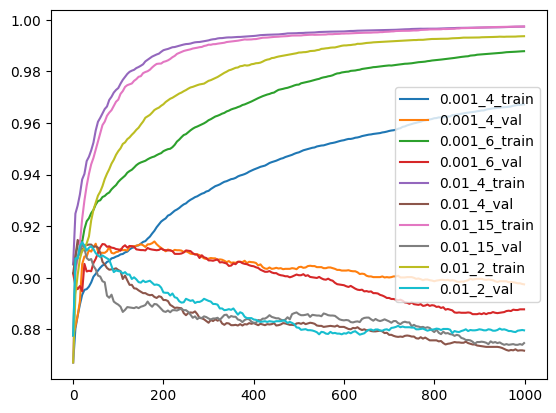

In [123]:
df_plot = df_score[df_score.eta == 0.001]
df_plot = df_plot[df_plot.max_depth == 4]
plt.plot(df_plot.num_iter, df_plot.train_auc, label='0.001_4_train')
plt.plot(df_plot.num_iter, df_plot.val_auc, label='0.001_4_val')

df_plot = df_score[df_score.eta == 0.001]
df_plot = df_plot[df_plot.max_depth == 6]
plt.plot(df_plot.num_iter, df_plot.train_auc, label='0.001_6_train')
plt.plot(df_plot.num_iter, df_plot.val_auc, label='0.001_6_val')

df_plot = df_score[df_score.eta == 0.01]
df_plot = df_plot[df_plot.max_depth == 4]
plt.plot(df_plot.num_iter, df_plot.train_auc, label='0.01_4_train')
plt.plot(df_plot.num_iter, df_plot.val_auc, label='0.01_4_val')

df_plot = df_score[df_score.eta == 0.01]
df_plot = df_plot[df_plot.max_depth == 15]
plt.plot(df_plot.num_iter, df_plot.train_auc, label='0.01_15_train')
plt.plot(df_plot.num_iter, df_plot.val_auc, label='0.01_15_val')

df_plot = df_score[df_score.eta == 0.01]
df_plot = df_plot[df_plot.max_depth == 2]
plt.plot(df_plot.num_iter, df_plot.train_auc, label='0.01_2_train')
plt.plot(df_plot.num_iter, df_plot.val_auc, label='0.01_2_val')

plt.legend()

In [133]:
%%capture output

score = []
for eta in [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]:
  for md in [2, 4, 6, 8, 10, 15]:
    xgb_params = {'eta': eta, 'max_depth': md, 'min_child_weight': 1, 'objective': 'binary:logistic', 'eval_metric': 'error', 'nthread': 8, 'seed': 1, 'verbosity': 1}   
    watchlist = [(dtrain, 'train'), (dval, 'val')]
    model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)
    for ni in range(0,201,5):
      score.append((eta, md))

df_score_error = pd.DataFrame(score, columns=['eta', 'max_depth'])
df_parse = parse_xgb_output(output)
df_score_error = pd.concat([df_score_error, df_parse], axis=1)

In [137]:
df_score_error.columns.str.replace('train_auc','train_error')
df_score_error.columns.str.replace('val_auc','val_error')
df_score_error.describe()

,eta,max_depth,num_iter,train_auc,val_auc
count,1722.000000,1722.000000,217.000000,217.000000,217.000000
mean,0.165857,7.500000,95.967742,0.184200,0.200965
std,0.169097,4.234038,60.078143,0.042674,0.031094
min,0.001000,2.000000,0.000000,0.132180,0.137930
25%,0.010000,4.000000,45.000000,0.147990,0.183910
50%,0.100000,7.000000,95.000000,0.181030,0.201150
75%,0.300000,10.000000,150.000000,0.202590,0.212640
max,0.500000,15.000000,199.000000,0.277300,0.270110


In [139]:
df_score_error.sort_values("val_auc", ascending=True).head(50)

,eta,max_depth,num_iter,train_auc,val_auc
67,0.001,4,130.0,0.19828,0.13793
66,0.001,4,125.0,0.19828,0.13793
69,0.001,4,140.0,0.19828,0.14368
68,0.001,4,135.0,0.19828,0.14368
78,0.001,4,185.0,0.19828,0.14943
79,0.001,4,190.0,0.19828,0.14943
77,0.001,4,180.0,0.19828,0.14943
76,0.001,4,175.0,0.19971,0.14943
75,0.001,4,170.0,0.19971,0.14943
81,0.001,4,199.0,0.19828,0.14943


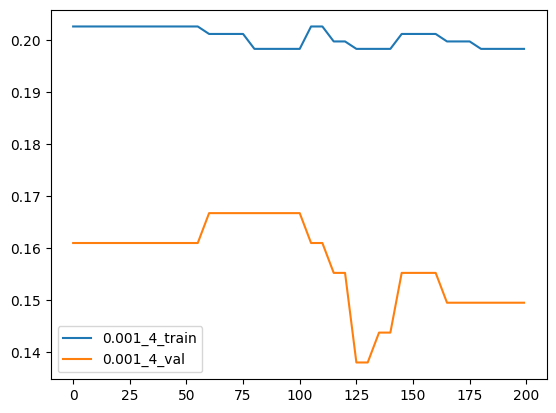

In [140]:
df_plot = df_score_error[df_score_error.eta == 0.001]
df_plot = df_plot[df_plot.max_depth == 4]
plt.plot(df_plot.num_iter, df_plot.train_auc, label='0.001_4_train')
plt.plot(df_plot.num_iter, df_plot.val_auc, label='0.001_4_val')

plt.legend()

In [125]:
# Functions to calculate XGBoost model
def XGB_train(df_train, df_val, features, xgb_params, num_rounds):
    train_dicts = df_train[features].to_dict(orient='records')
    val_dicts = df_val[features].to_dict(orient='records')
    dv = DictVectorizer(sparse=False) # OHE
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)
    #X_train = df_train[features].values
    #X_val = df_val[features].values

    y_train = df_train.transported.values
    y_val = df_val.transported.values
    

    features = dv.get_feature_names_out()
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
    model = xgb.train(xgb_params, dtrain, num_boost_round=num_rounds)

    return(dv,model,dtrain,dval)
  
def XGB_predict(dtrain, dval, model):
    y_pred_train = model.predict(dtrain)
    y_pred_val = model.predict(dval)

    return(y_pred_train, y_pred_val)

def XGB_calculate(features, xgb_params, num_rounds=100, print_kfold=True, print_summary=True,n_splits=5):
    # Cross-Validating
    print('ETA: ', xgb_params['eta'], 'max_depth: ', xgb_params['max_depth'], 'num_rounds: ', num_rounds)
    if print_kfold: print('Doing validation with %s splits' % n_splits)
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores_train = []
    scores_val = []
    fold = 0

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        dv, model, dtrain, dval = XGB_train(df_train, df_val, features, xgb_params, num_rounds)
        y_pred_train, y_pred_val = XGB_predict(dtrain, dval, model)

        y_train = df_train.transported.values
        y_val = df_val.transported.values
        scores_train.append(round(roc_auc_score(y_train, y_pred_train),4))
        scores_val.append(round(roc_auc_score(y_val, y_pred_val),4))

        # Calculates and prints metrics
        if print_kfold: print(f'Fold {fold} ROC_AUC train: {round(roc_auc_score(y_train, y_pred_train),4)} ROC_AUC val: {round(roc_auc_score(y_val, y_pred_val),4)}...')
        fold = fold + 1

    if print_kfold: print('Validation results:')
    if print_kfold: print('ROC_AUC_train: %.3f +- %.3f' % (np.mean(scores_train), np.std(scores_train))) 
    if print_kfold: print('ROC_AUC_val: %.3f +- %.3f' % (np.mean(scores_val), np.std(scores_val))) 

    #Final model
    if print_summary: print("Final model...")
    dv, model, dtrain, dtest = XGB_train(df_full_train, df_test, features, xgb_params, num_rounds)
    y_pred_train, y_pred_test = XGB_predict(dtrain, dtest, model)

    y_train = df_full_train.transported.values
    y_test = df_test.transported.values
   
    if print_summary: print('ROC_AUC train: ',round(roc_auc_score(y_train, y_pred_train),4), ' ROC_AUC test: ',round(roc_auc_score(y_test, y_pred_test),4))
      
    return [xgb_params['eta'], xgb_params['max_depth'], num_rounds,
          round(roc_auc_score(y_train, y_pred_train),4), round(roc_auc_score(y_test, y_pred_test),4)
          ], dv, model

In [ ]:
scores=[]

features = ['homeplanet', 'cryosleep', 'cabin', 'destination', 'age',
            'vip', 'roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck']
     
for eta in [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]:
  for md in [2, 4, 6, 10, 15]:
    for nb in [10, 20, 30, 50, 100, 200, 500]:
      xgb_params = {'eta': eta, 'max_depth': md, 'min_child_weight': 1, 'objective': 'reg:squarederror', 'nthread': 8, 'seed': 1, 'verbosity': 1}
      sc,model= XGB_calculate(features, xgb_params, nb, True, False, False)
      scores.append(sc)

df_scores =pd.DataFrame(scores,columns=['eta', 'max_depth', 'num_rounds', 'rmsle_train', 'rmsle_val'])

df_scores.describe()

In [16]:
df.columns

Index(['passengerid', 'homeplanet', 'cryosleep', 'cabin', 'destination', 'age',
       'vip', 'roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck',
       'name', 'transported'],
      dtype='object')

In [128]:
features = ['homeplanet', 'cryosleep', 'cabin', 'destination', 'age',
            'vip', 'roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck']
xgb_params = {'eta': 0.001, 'max_depth': 4, 'min_child_weight': 1, 'objective': 'binary:logistic', 'nthread': 8, 'seed': 1, 'verbosity': 1}
a, dv, model = XGB_calculate(features, xgb_params, 500, True, True)

ETA:  0.001 max_depth:  4 num_rounds:  500
Doing validation with 5 splits
Fold 0 ROC_AUC train: 0.9092 ROC_AUC val: 0.837...
Fold 1 ROC_AUC train: 0.8866 ROC_AUC val: 0.9062...
Fold 2 ROC_AUC train: 0.9062 ROC_AUC val: 0.8575...
Fold 3 ROC_AUC train: 0.9222 ROC_AUC val: 0.7568...
Fold 4 ROC_AUC train: 0.8915 ROC_AUC val: 0.8803...
Validation results:
ROC_AUC_train: 0.903 +- 0.013
ROC_AUC_val: 0.848 +- 0.051
Final model...
ROC_AUC train:  0.9015  ROC_AUC test:  0.9081


In [24]:
features = ['homeplanet', 'cryosleep', 'cabin', 'destination', 'age',
            'vip', 'roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck']
xgb_params = {'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'objective': 'binary:logistic', 'nthread': 8, 'seed': 1, 'verbosity': 1}
a, dv, model = XGB_calculate(features, xgb_params, 200, True, True)

ETA:  0.01 max_depth:  6 num_rounds:  200
Doing validation with 5 splits
Fold 0 ROC_AUC train: 0.9562 ROC_AUC val: 0.8373...
Fold 1 ROC_AUC train: 0.949 ROC_AUC val: 0.9075...
Fold 2 ROC_AUC train: 0.9554 ROC_AUC val: 0.8747...
Fold 3 ROC_AUC train: 0.9668 ROC_AUC val: 0.7466...
Fold 4 ROC_AUC train: 0.953 ROC_AUC val: 0.8692...
Validation results:
ROC_AUC_train: 0.956 +- 0.006
ROC_AUC_val: 0.847 +- 0.055
Final model...
ROC_AUC train:  0.9491  ROC_AUC test:  0.9113


In [45]:
dv.get_feature_names_out()

array(['age', 'cabin', 'cabin=a/103/s', 'cabin=a/104/s', 'cabin=a/17/s',
       'cabin=a/22/s', 'cabin=a/30/s', 'cabin=a/4/p', 'cabin=a/43/p',
       'cabin=a/48/s', 'cabin=a/54/s', 'cabin=a/59/p', 'cabin=a/60/s',
       'cabin=a/62/s', 'cabin=a/64/p', 'cabin=a/67/s', 'cabin=a/77/p',
       'cabin=a/8/s', 'cabin=a/85/p', 'cabin=a/90/p', 'cabin=b/103/s',
       'cabin=b/118/p', 'cabin=b/118/s', 'cabin=b/123/s', 'cabin=b/127/p',
       'cabin=b/128/p', 'cabin=b/130/s', 'cabin=b/131/s', 'cabin=b/132/s',
       'cabin=b/146/s', 'cabin=b/147/s', 'cabin=b/148/s', 'cabin=b/160/p',
       'cabin=b/161/s', 'cabin=b/162/p', 'cabin=b/166/s', 'cabin=b/180/s',
       'cabin=b/184/s', 'cabin=b/185/p', 'cabin=b/187/p', 'cabin=b/193/s',
       'cabin=b/20/s', 'cabin=b/201/p', 'cabin=b/205/s', 'cabin=b/210/s',
       'cabin=b/216/p', 'cabin=b/217/s', 'cabin=b/218/s', 'cabin=b/226/s',
       'cabin=b/250/p', 'cabin=b/269/p', 'cabin=b/280/p', 'cabin=b/286/s',
       'cabin=b/291/p', 'cabin=b/293/p', 'cab

In [25]:
import pickle

with open('XGB_model_2.bin', 'wb') as f_out: 
    pickle.dump((dv, model), f_out)

In [54]:
model_file = 'XGB_model.bin'
with open(model_file, 'rb') as f_in:
    dv, model = pickle.load(f_in)

passenger = {
  "homeplanet": "europa",
  "cryosleep": 0,
  "cabin": "e/608/s",
  "destination": "55_cancri_e",
  "age": 32,
  "vip": 0,
  "roomservice": 0,
  "foodcourt": 1049,
  "shoppingmall": 0,
  "spa": 353,
  "vrdeck": 3235
}

X = dv.transform(passenger)
features = dv.get_feature_names_out()
dX = xgb.DMatrix(X, feature_names=features)
y_pred = model.predict(dX)

y_pred
passenger


{'homeplanet': 'europa',
 'cryosleep': 0,
 'cabin': 'e/608/s',
 'destination': '55_cancri_e',
 'age': 32,
 'vip': 0,
 'roomservice': 0,
 'foodcourt': 1049,
 'shoppingmall': 0,
 'spa': 353,
 'vrdeck': 3235}